In [70]:
# !pip install torch --user

In [71]:
import io
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

## Carregamento dos dados

In [72]:
dct = {}
dct['codigo'] = 'soja'

In [73]:
df = pd.read_pickle(f'../dados/cepea-{dct["codigo"]}.p')

In [74]:
# Converte index para data
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

# Slice para somente o período desejado
df = df['01/01/2007':'01/01/2021']

In [75]:
df.drop(columns=['preco_real'], axis=1, inplace=True)

In [76]:
# Como uma possível sazonalidade nos preços deve ter ciclo anual, com variação mensal, 
# faremos o resample da série para a média de cada mês
df_mes = df.resample('MS').mean()
df.isnull().any()

preco_dolar    False
dtype: bool

<AxesSubplot:xlabel='data'>

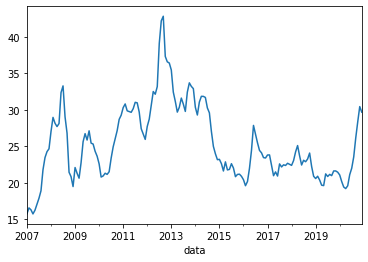

In [77]:
df_mes.preco_dolar.plot()

In [78]:
# Gera train e test sets
def gera_sets(df, sep_rule):
    tr = df.preco_dolar[~sep_rule]
    tt = df.preco_dolar[sep_rule]
    return tr, tt

# Primeiro, faremos os modelos na periodicidade mensal
sep = df_mes.index.year >= 2019
train, test = gera_sets(df_mes, sep)

# Depois, os modelos diários
sep_oa = df.index.year >= 2020
sep_om = df.index.month > 6
sep_o = sep_oa & sep_om
train_o, test_o = gera_sets(df, sep_o)

In [79]:
# Normalização dos dados
def normaliza(treino, teste):
    scaler = StandardScaler()
    fit_scaler = scaler.fit(treino.values.reshape(-1,1))       # fit
    ntreino = fit_scaler.transform(treino.values.reshape(-1,1)) # transforma treino
    nteste = fit_scaler.transform(teste.values.reshape(-1,1))   # transforma teste
    return ntreino, nteste, scaler

# Aplica
n_train, n_test, n_scaler = normaliza(train, test)
no_train, no_test, no_scaler = normaliza(train_o, test_o)

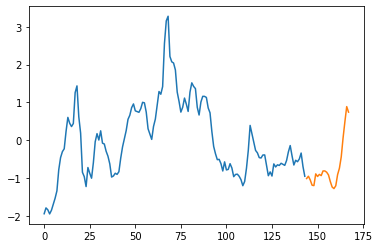

In [80]:
# Mesmo comportamento dos dados do gráfico
plt.plot(range(len(n_train)),n_train)
plt.plot(range(len(n_train),len(n_train)+len(n_test)),n_test)

In [81]:
print(n_test.size)
print(no_test.size)

24
126


In [82]:
# Unindo novamente o train e o teste, para criar a window de entrada da LSTM
# Caso contrário, a função criaria um gap entre as duas variaveis igual ao tamanho do número simultaneo de
# observações usadas como features
full_set = np.r_[n_train,n_test]
print(full_set.size)

fullo_set = np.r_[no_train,no_test]
print(fullo_set.size)

168
3492


# <center>Desenvolvimento de Modelos Preditivos</center>

---

## MODELO LSTM

Conversão para tensores

In [83]:
# Conversão dos dados em tensores
tensor = torch.FloatTensor(full_set).view(-1) # dados mensais
tensoro = torch.FloatTensor(fullo_set).view(-1) # dados diários

In [84]:
# Transforma a entrada em uma sequência de N inputs para cada observação da saída
    
train_window = 24
traino_window = 250

def create_seq(input_data, tw):
    L = len(input_data)
    x = []
    y = []
    for i in range(L-tw):
        x.append(input_data[i:i+tw])
        y.append(input_data[i+tw:i+tw+1])

    return x, y

x_list, y_list = create_seq(tensor, train_window) # dados mensais
xo_list, yo_list = create_seq(tensoro, traino_window) # dados diarios

In [85]:
# Converte em tensor
def list_to_tensor(lista_de_tensores):
    t = torch.zeros(len(lista_de_tensores),lista_de_tensores[0].size()[0])
    for e, tensor in enumerate(lista_de_tensores):
        t[e] = tensor
    return t

def call_ltt(x,y,t):
    fxtr = list_to_tensor(x[:-t.shape[0]]).unsqueeze(2)
    fytr = list_to_tensor(y[:-t.shape[0]])
    fxtt = list_to_tensor(x[-t.shape[0]:]).unsqueeze(2)
    fytt = list_to_tensor(y[-t.shape[0]:])
    return fxtr, fytr, fxtt, fytt

xtr, ytr, xtt, ytt = call_ltt(x_list, y_list, n_test)
xtro, ytro, xtto, ytto = call_ltt(xo_list, yo_list, no_test)

---

## Criação da REDE NEURAL RNN - LSTM com Pytorch  
</br>

In [86]:
#####################
# Modelo
#####################

class LSTM(nn.Module):

    def __init__(self, n_features, hidden_dim, seq_len, batch, num_layers=2):
        super(LSTM, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.batch = batch
        self.num_layers = num_layers

        # Define Camada LSTM
        self.lstm = nn.LSTM(
            input_size=self.n_features, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            dropout =.1, # (só pode ser utilizado dropout se número de camadas LSTM for superior a 1 )
        )

        # Define camada linear
        self.linear = nn.Linear(
            in_features=self.hidden_dim, 
            out_features=1
        )
        
        
    def reset_hidden_layer(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.batch, self.hidden_dim),
            torch.zeros(self.num_layers, self.batch, self.hidden_dim)
        )

    def forward(self, input):
        
        lstm_out, self.hidden = self.lstm(
            input
        )

        y_pred = self.linear(
            lstm_out[:,-1,:]
        )
        
        return y_pred

In [87]:
#####################
# Treinamento
#####################

def train_model(model, epochs, train_data, train_labels, test_data, test_labels):
    
    num_epochs = epochs
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    loss_fn = torch.nn.L1Loss() # função de erro MAE
    learning_rate = 1e-3
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for t in range(num_epochs):
        
        model.reset_hidden_layer()
        
        y_pred = model(X_train) # Realiza o Forward
        
        loss = loss_fn(y_pred.float(), y_train)
    
        with torch.no_grad(): # Previne atualização de parâmetros
            y_test_pred = model(X_test)
            test_loss = loss_fn(y_test_pred.float(), y_test)
        test_hist[t] = test_loss.item()

        if t % 10 == 0:  
            print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

        train_hist[t] = loss.item()
              
        loss.backward()

        optimiser.step()
    
        optimiser.zero_grad()

    return  model.eval(), train_hist, test_hist, y_pred.float(), y_test_pred.float()

#### MODELO MENSAL

In [88]:
hi = 17 # nós no hidden layer
epochs = 200
num_layers = 2 # layers LSTM

In [89]:
# Treina na periodicidade mensal
X_train, y_train, X_test, y_test = xtr, ytr, xtt, ytt

In [90]:
print(X_train.size())
print(y_train.size())
print(X_test.size())
print(y_test.size())

torch.Size([120, 24, 1])
torch.Size([120, 1])
torch.Size([24, 24, 1])
torch.Size([24, 1])


In [91]:
batch = X_train.size()[0]

# train_window depende se mensal ou diario, definida anteriormente
model = LSTM(1, hi, seq_len=train_window, batch=batch, num_layers=num_layers)

In [92]:
model, train_hist, test_hist, pred_train, pred_test = train_model(model, epochs, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 0.764156699180603 test loss: 0.811662495136261
Epoch 10 train loss: 0.7394883632659912 test loss: 0.7700936198234558
Epoch 20 train loss: 0.6993881464004517 test loss: 0.7226249575614929
Epoch 30 train loss: 0.6182951331138611 test loss: 0.6490139365196228
Epoch 40 train loss: 0.529955267906189 test loss: 0.557399332523346
Epoch 50 train loss: 0.4876507520675659 test loss: 0.5499024987220764
Epoch 60 train loss: 0.45047298073768616 test loss: 0.5223949551582336
Epoch 70 train loss: 0.42550262808799744 test loss: 0.5135447978973389
Epoch 80 train loss: 0.4001133143901825 test loss: 0.49931976199150085
Epoch 90 train loss: 0.3805350959300995 test loss: 0.48293495178222656
Epoch 100 train loss: 0.3582991659641266 test loss: 0.45102497935295105
Epoch 110 train loss: 0.3391846716403961 test loss: 0.46076783537864685
Epoch 120 train loss: 0.33388927578926086 test loss: 0.4103294610977173
Epoch 130 train loss: 0.30977481603622437 test loss: 0.41491201519966125
Epoch 140 tr

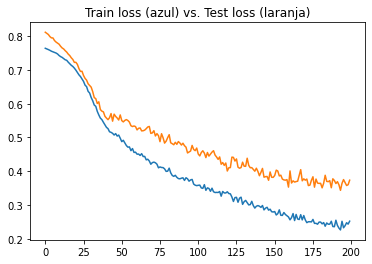

In [93]:
plt.title("Train loss (azul) vs. Test loss (laranja)")
plt.plot(train_hist)
plt.plot(test_hist)

In [94]:
# tr = [x.detach().numpy()[0] for x in pred_train]
# ts = [x.detach().numpy()[0] for x in pred_test]

# tr_normalized = fit_scaler.inverse_transform(tr)
# tt_normalized = fit_scaler.inverse_transform(ts)

# doze = [np.mean(tr_normalized)] * train_window
# tr_doze = np.r_[doze,tr_normalized] # Adiciona itens ao começo da array, para ressincronizar aos dados originais

# # Compara

# plt.figure(figsize=(16,8))
# plt.title('Variável observada (laranja) versus Predita (vermelho)')
# plt.plot(range(len(train.values)),train.values, color='blue')
# plt.plot(range(len(train.values),len(train.values)+len(test.values)),test.values, color='orange')
# plt.plot(range(len(tr_doze)),tr_doze, color='green')
# plt.plot(range(len(tr_doze),len(tr_doze)+len(tt_normalized)),tt_normalized, color='red')

In [95]:
# plt.figure(figsize=(16,8))
# plt.plot(range(len(train.values)),train.values, 'o')
# plt.plot(range(len(train.values),len(train.values)+len(test.values)),test.values, 'o')
# plt.plot(range(len(tr_doze)),tr_doze)
# plt.plot(range(len(tr_doze),len(tr_doze)+len(tt_normalized)),tt_normalized)

---
#### MODELO DIÁRIO

In [96]:
hi = 34 # nós no hidden layer
epochs = 200
num_layers = 2 # layers LSTM

In [97]:
# Treina na periodicidade mensal
X_train, y_train, X_test, y_test = xtro, ytro, xtto, ytto

In [98]:
print(X_train.size())
print(y_train.size())
print(X_test.size())
print(y_test.size())

torch.Size([3116, 250, 1])
torch.Size([3116, 1])
torch.Size([126, 250, 1])
torch.Size([126, 1])


In [99]:
batch = X_train.size()[0]

# train_window depende se mensal ou diario, definida anteriormente
model = LSTM(1, hi, seq_len=traino_window, batch=batch, num_layers=num_layers)

In [100]:
model, train_hist, test_hist, pred_train, pred_test = train_model(model, epochs, X_train, y_train, X_test, y_test)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 136000 bytes. Buy new RAM!

In [ ]:
plt.title("Train loss (azul) vs. Test loss (laranja)")
plt.plot(train_hist)
plt.plot(test_hist)

In [ ]:
# tr = [x.detach().numpy()[0] for x in pred_train]
# ts = [x.detach().numpy()[0] for x in pred_test]

# tr_normalized = fit_scaler.inverse_transform(tr)
# tt_normalized = fit_scaler.inverse_transform(ts)

# doze = [np.mean(tr_normalized)] * train_window
# tr_doze = np.r_[doze,tr_normalized] # Adiciona itens ao começo da array, para ressincronizar aos dados originais

# # Compara

# plt.figure(figsize=(16,8))
# plt.title('Variável observada (laranja) versus Predita (vermelho)')
# plt.plot(range(len(train.values)),train.values, color='blue')
# plt.plot(range(len(train.values),len(train.values)+len(test.values)),test.values, color='orange')
# plt.plot(range(len(tr_doze)),tr_doze, color='green')
# plt.plot(range(len(tr_doze),len(tr_doze)+len(tt_normalized)),tt_normalized, color='red')

In [ ]:
# plt.figure(figsize=(16,8))
# plt.plot(range(len(train.values)),train.values, 'o')
# plt.plot(range(len(train.values),len(train.values)+len(test.values)),test.values, 'o')
# plt.plot(range(len(tr_doze)),tr_doze)
# plt.plot(range(len(tr_doze),len(tr_doze)+len(tt_normalized)),tt_normalized)